In [1]:
# Try making the NuSTAR solar temperature response in python
# uses the output of f_vth() from make_fvtharray.pro

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.io as io

import warnings
warnings.simplefilter('ignore')

In [2]:
fvth=io.readsav('fvth_out.dat')

In [3]:
# in units of keV
engs=fvth['eng']
de=engs[0]-engs[1]
logt=fvth['logt']
# in units of photons/s/keV/cm2
phmod=np.array(fvth['fvth'])

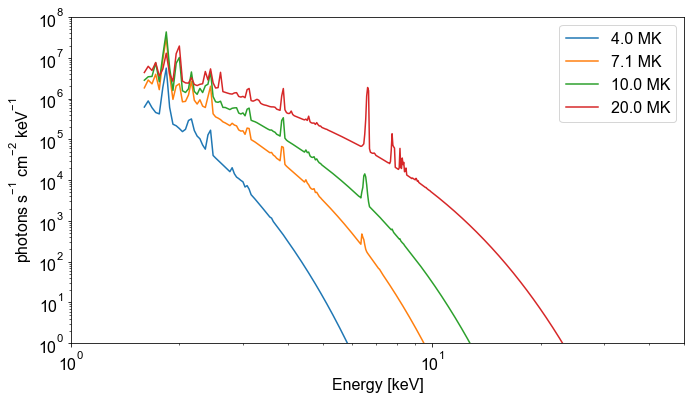

In [4]:
# Check the thermal photon models look ok
plt.rcParams.update({'font.size': 16,'font.family':"sans-serif",\
                     'font.sans-serif':"Arial",'mathtext.default':"regular"})
fig = plt.figure(figsize=(11, 6))
plt.loglog(engs,phmod[:,11],label=str(round(10**(logt[11])*1e-6,1))+' MK')
plt.loglog(engs,phmod[:,16],label=str(round(10**(logt[16])*1e-6,1))+' MK')
plt.loglog(engs,phmod[:,19],label=str(round(10**(logt[19])*1e-6,1))+' MK')
plt.loglog(engs,phmod[:,25],label=str(round(10**(logt[25])*1e-6,1))+' MK')

plt.ylim([1e0,1e8])
plt.xlim([1.,50])
plt.xlabel('Energy [keV]')
plt.ylabel('${photons\;s^{-1}\;cm^{-2}\;keV^{-1}}$')
plt.legend()
fig.show()

In [5]:
# Need to load in the pha, arf and rmf

# Then for the response need to do (1e49 as that's the EM used with f_vth)
# TR = (RMF*ARF) # (phmod*dE/1e49)
# [counts cm^3/s] = [counts cm^2/photons]*[photons/cm^2/s/keV]*[keV]/cm^-3

In [6]:
print(round(10**logt[16]*1e-6,2))

7.08
